# OpenCV center of contour

With this in mind, the goal of today’s tutorial is to (1) detect the outline of each shape in the image, followed by (2) computing the center of the contour — also called the centroid of the region.

In order to accomplish these goals, we’ll need to perform a bit of image pre-processing, including:

* Conversion to grayscale.
* Blurring to reduce high frequency noise to make our contour detection process more accurate.
* Binarization of the image. Typically edge detection and thresholding are used for this process. In this post, we’ll be applying thresholding.


### Import Packages

In [1]:
# import the necessary packages
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import time
import glob
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [2]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### OpenCV center of contour

In [3]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to the input image")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "data/shapes_and_colors.png"
}

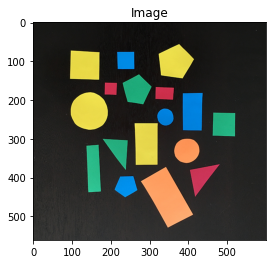

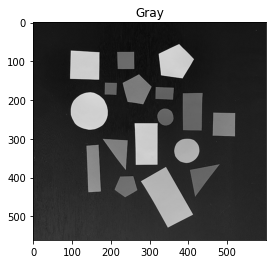

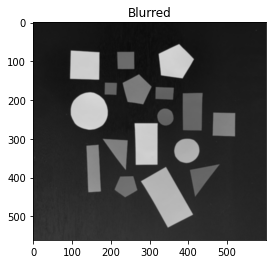

In [4]:
# load the image, convert it to grayscale, blur it slightly,
# and threshold it
image = cv2.imread(args["image"])
plt_imshow("Image", image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt_imshow("Gray", gray)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt_imshow("Blurred", blurred)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
plt_imshow("Thresh", thresh)

In [5]:
# find contours in the thresholded image
# A call to cv2.findContours returns the set of outlines (i.e., contours) that correspond to each of the white blobs on the image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
#cnts = imutils.grab_contours(cnts) => use when we not know version of opencv

We start looping over each of the individual contours, followed by computing image moments for the contour region.

In computer vision and image processing, image moments are often used to characterize the shape of an object in an image. These moments capture basic statistical properties of the shape, including the area of the object, the centroid (i.e., the center (x, y)-coordinates of the object), orientation, along with other desirable properties.

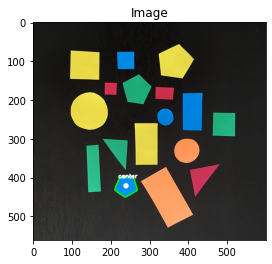

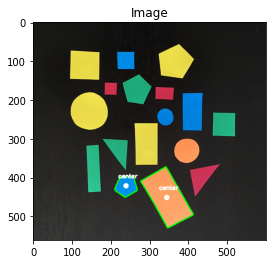

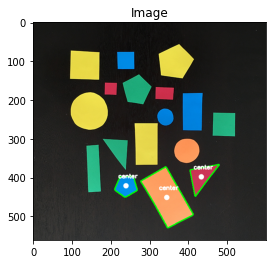

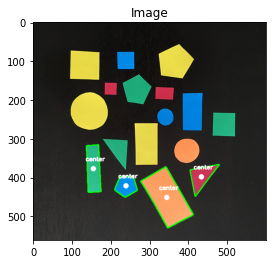

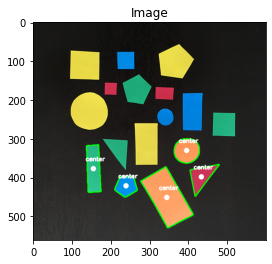

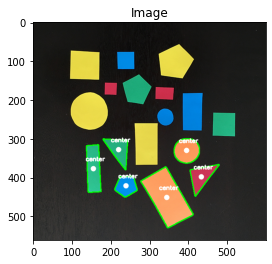

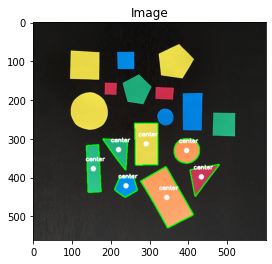

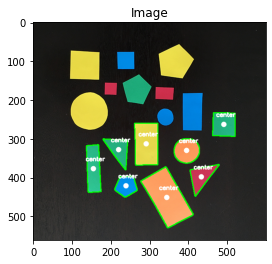

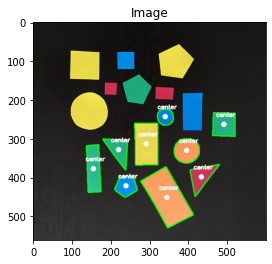

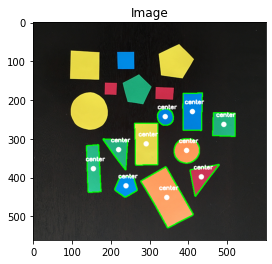

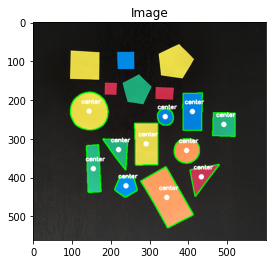

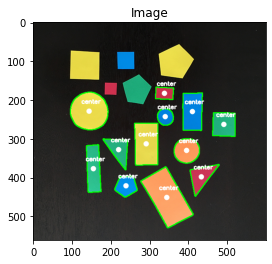

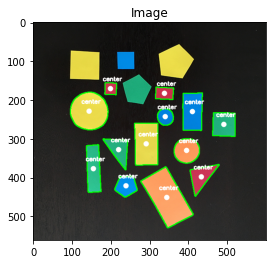

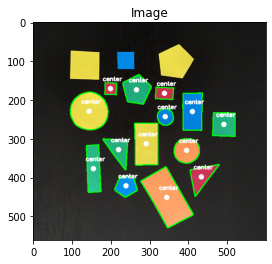

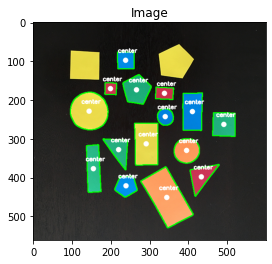

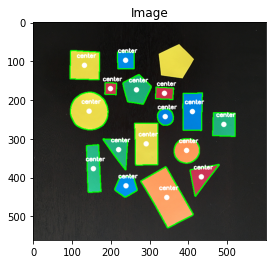

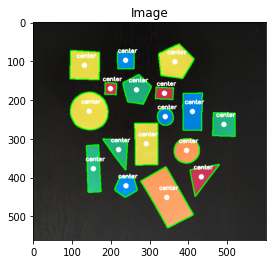

In [6]:
# loop over the contours
for c in cnts:
	# compute the center of the contour
	M = cv2.moments(c)
	cX = int(M["m10"] / M["m00"])
	cY = int(M["m01"] / M["m00"])

	# draw the contour and center of the shape on the image
	cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
	cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
	cv2.putText(image, "center", (cX - 20, cY - 20),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

	# show the image
	plt_imshow("Image", image)

# OpenCV shape detection


### Defining our shape detector

In order to perform shape detection, we’ll be using contour approximation.

As the name suggests, contour approximation is an algorithm for reducing the number of points in a curve with a reduced set of points — thus the term approximation.

This algorithm is commonly known as the Ramer-Douglas-Peucker algorithm, or simply the split-and-merge algorithm.

Contour approximation is predicated on the assumption that a curve can be approximated by a series of short line segments. This leads to a resulting approximated curve that consists of a subset of points that were defined by the original curve.

In order to perform contour approximation, we first compute the perimeter of the contour, followed by constructing the actual contour approximation.

Common values for the second parameter to cv2.approxPolyDP are normally in the range of 1-5% of the original contour perimeter.

In [7]:
class ShapeDetector:
	def __init__(self):
		pass

	def detect(self, c):
		# initialize the shape name and approximate the contour(c)
		shape = "unidentified"
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.04 * peri, True) # return list of vertices

		# if the shape is a triangle, it will have 3 vertices
		if len(approx) == 3:
			shape = "triangle"

		# if the shape has 4 vertices, it is either a square or
		# a rectangle
		elif len(approx) == 4:
			# compute the bounding box of the contour and use the
			# bounding box to compute the aspect ratio
			(x, y, w, h) = cv2.boundingRect(approx)
			ar = w / float(h)

			# a square will have an aspect ratio that is approximately
			# equal to one, otherwise, the shape is a rectangle
			shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

		# if the shape is a pentagon, it will have 5 vertices
		elif len(approx) == 5:
			shape = "pentagon"

		# otherwise, we assume the shape is a circle
		else:
			shape = "circle"

		# return the name of the shape
		return shape

### Shape detection with OpenCV

In [8]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to the input image")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "data/shapes_and_colors.png"
}

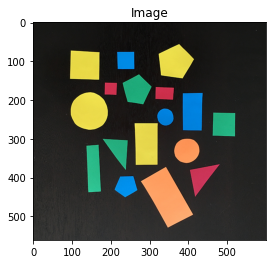

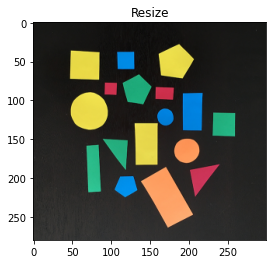

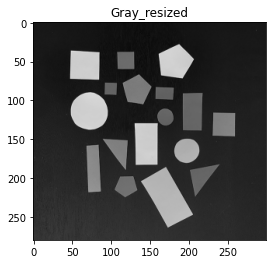

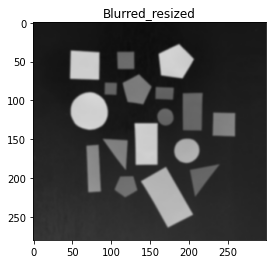

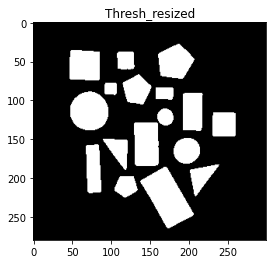

In [9]:
# load the image and resize it to a smaller factor so that
# the shapes can be approximated better
image = cv2.imread(args["image"])
plt_imshow("Image", image)
resized = imutils.resize(image, width=300)
plt_imshow("Resize", resized)
ratio = image.shape[0] / float(resized.shape[0])

# convert the resized image to grayscale, blur it slightly,
# and threshold it
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
plt_imshow("Gray_resized", gray)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt_imshow("Blurred_resized", blurred)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
plt_imshow("Thresh_resized", thresh)

# find contours in the thresholded image and initialize the
# shape detector
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)[0]
#cnts = imutils.grab_contours(cnts)
sd = ShapeDetector()

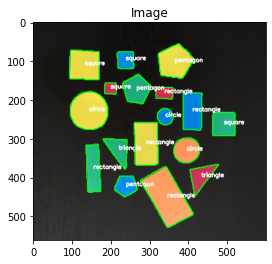

In [10]:
# loop over the contours
for c in cnts:
	# compute the center of the contour, then detect the name of the
	# shape using only the contour
	M = cv2.moments(c)
	cX = int((M["m10"] / M["m00"]) * ratio)
	cY = int((M["m01"] / M["m00"]) * ratio)
	shape = sd.detect(c)

	# multiply the contour (x, y)-coordinates by the resize ratio,
	# then draw the contours and the name of the shape on the image
	c = c.astype("float")
	c *= ratio
	c = c.astype("int")
	cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
	cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
		0.5, (255, 255, 255), 2)

# show the output image
plt_imshow("Image", image)

# OpenCV Template Matching (cv2.matchTemplate)

Other than contour filtering and processing, template matching is arguably one of the most simple forms of object detection:

* It’s simple to implement, requiring only 2-3 lines of code
* Template matching is computationally efficient
* It doesn’t require you to perform thresholding, edge detection, etc., to generate a binary image (such as contour detection and processing does)
* And with a basic extension, template matching can detect multiple instances of the same/similar object in an input image (which we’ll cover next week)

Of course, template matching isn’t perfect. Despite all the positives, template matching quickly fails if there are factors of variation in your input images, including changes to rotation, scale, viewing angle, etc.

If your input images contain these types of variations, you should not use template matching — utilize dedicated object detectors including HOG + Linear SVM, Faster R-CNN, SSDs, YOLO, etc.

## What is template matching?
<image src="images/template_matching_pipeline.png">

We require two images to apply template matching:

1. Source image: This is the image we expect to find a match to our template in.
2. Template image: The “object patch” we are searching for in the source image.

To find the template in the source image, we slide the template from left-to-right and top-to-bottom across the source:

<image src="images/template_matching_sliding.png">

At each (x, y)-location, a metric is calculated to represent how “good” or “bad” the match is. Typically, we use the normalized correlation coefficient to determine how “similar” the pixel intensities of the two patches are:

<image src="images/template_matching_ccoef_normed.png">

For each location T over I, the computed result metric is stored in our result matrix R. Each (x, y)-coordinate in the source image (that also has a valid width and height for the template image) contains an entry in the result matrix R

<image src="images/template_matching_result_matrix.png">

Here, we can visualize our result matrix R overlaid on the original image. Notice how R is ***not*** the same size as the original template. This is because the entire template must fit inside the source image for the correlation to be computed. If the template exceeds the source’s boundaries, we do not compute the similarity metric.

**Bright locations of the result matrix R indicate the best matches, where dark regions indicate there is very little correlation between the source and template images**. Notice how the result matrix’s brightest region appears at the coffee mug’s upper-left corner.

While template matching is extremely simple and computationally efficient to apply, there are many limitations. If there are any object scale variations, rotation, or viewing angle, template matching will likely fail.

In nearly all cases, you’ll want to ensure that the template you are detecting is nearly identical to the object you want to detect in the source. Even small, minor deviations in appearance can dramatically affect template matching results and render it effectively useless.

## OpenCV’s “cv2.matchTemplate” function
We can apply template matching using OpenCV and the cv2.matchTemplate function:

result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

Here, you can see that we are providing the cv2.matchTemplate function with three parameters:

1. The input image that contains the object we want to detect
2. The template of the object (i.e., what we want to detect in the image)
3. The template matching method
Here, we are using the normalized correlation coefficient, which is typically the template matching method you’ll want to use, but OpenCV supports other template matching methods as well.

The output result from cv2.matchTemplate is a matrix with spatial dimensions:

* Width: image.shape[1] - template.shape[1] + 1
* Height: image.shape[0] - template.shape[0] + 1
We can then find the location in the result that has the maximum correlation coefficient, which corresponds to the most likely region that the template can be found in (which you’ll learn how to do later in this tutorial).

It’s also worth noting that if you wanted to detect objects within only a specific region of an input image, you could supply a mask, like the following:

result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED, mask)

The mask must have the same spatial dimensions and data type as the template. For regions of the input image you don’t want to be searched, the mask should be set to zero. For regions of the image you want to be searched, be sure the mask has a corresponding value of 255.

### Implementing template matching with OpenCV

In [11]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str, required=True,
# 	help="path to input image where we'll apply template matching")
# ap.add_argument("-t", "--template", type=str, required=True,
# 	help="path to template image")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
# 8_diamonds.png coke_bottle.png coke_bottle_rotated.png
# coke_logo.png diamonds_template.png
args = {
    "image": "data/coke_bottle.png",
    "template": "data/coke_logo.png"
}

[INFO] loading images...


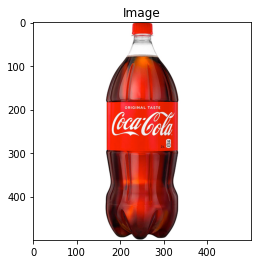

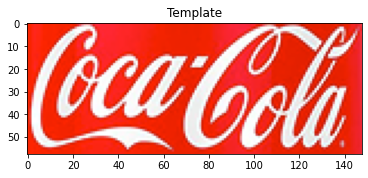

In [12]:
# load the input image and template image from disk, then display
# them to  our screen
print("[INFO] loading images...")
image = cv2.imread(args["image"])
template = cv2.imread(args["template"])
plt_imshow("Image", image)
plt_imshow("Template", template)

# convert both the image and template to grayscale
imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

Typically the normalized correlation coefficient (cv2.TM_CCOEF_NORMED) works well in most situations, [but you can refer to the OpenCV documentation for more details on other template matching methods](https://docs.opencv.org/3.4/de/da9/tutorial_template_matching.html).

Once we’ve applied the cv2.matchTemplate, we receive a result matrix with the following spatial dimensions:

* Width: image.shape[1] - template.shape[1] + 1
* Height: image.shape[0] - template.shape[0] + 1

The result matrix will have a large value (closer to 1), where there is more likely to be a template match. Similarly, the result matrix will have a small value (closer to 0), where matches are less likely.

To find the location with the largest value, and therefore the most likely match, we make a call to cv2.minMaxLoc (Line 29), passing in the result matrix.

In [13]:
# perform template matching
print("[INFO] performing template matching...")
result = cv2.matchTemplate(imageGray, templateGray, cv2.TM_CCOEFF_NORMED)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

[INFO] performing template matching...


Once we have the (x, y)-coordinates of the location with the largest normalized correlation coefficient (maxLoc), we can extract the coordinates and derive the bounding box coordinates:

In [14]:
# determine the starting and ending (x, y)-coordinates of the
# bounding box
(startX, startY) = maxLoc
endX = startX + template.shape[1]
endY = startY + template.shape[0]

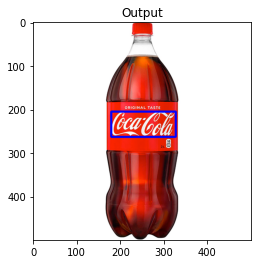

In [15]:
# draw the bounding box on the image
cv2.rectangle(image, (startX, startY), (endX, endY), (255, 0, 0), 3)

# show the output image
plt_imshow("Output", image)

# Multi-template matching with OpenCV

We could only detect one object because we were using the cv2.minMaxLoc function to find the single location with the largest normalized correlation score.

To perform multi-object template matching, what we instead need to do is:

1. Apply the cv2.matchTemplate function as we normally would
2. Find all (x, y)-coordinates where the template matching result matrix is greater than a preset threshold score
3. Extract all of these regions
4. Apply non-maxima suppression to them

In [16]:
from imutils.object_detection import non_max_suppression

In [17]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str, required=True,
# 	help="path to input image where we'll apply template matching")
# ap.add_argument("-t", "--template", type=str, required=True,
# 	help="path to template image")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
# 8_diamonds.png coke_bottle.png coke_bottle_rotated.png
# coke_logo.png diamonds_template.png
args = {
    "image": "data/8_diamonds.png",
    "template": "data/diamonds_template.png",
    "threshold": 0.8 
}

[INFO] loading images...


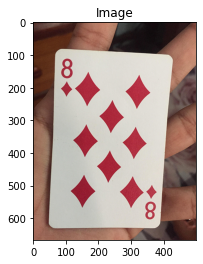

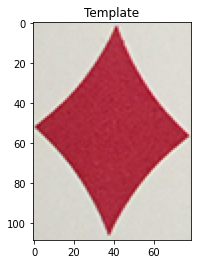

In [18]:
# load the input image and template image from disk, then grab the
# template image spatial dimensions
print("[INFO] loading images...")
image = cv2.imread(args["image"])
template = cv2.imread(args["template"])
(tH, tW) = template.shape[:2]

# display the  image and template to our screen
plt_imshow("Image", image)
plt_imshow("Template", template)

In [19]:
# convert both the image and template to grayscale
imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# perform template matching
print("[INFO] performing template matching...")
result = cv2.matchTemplate(imageGray, templateGray, cv2.TM_CCOEFF_NORMED)

[INFO] performing template matching...


We then apply the np.where function to find all (x, y)-coordinates with a normalized correlation coefficient greater than our preset threshold — this thresholding step allows us to perform multi-template matching!

The final step, which we’ll cover later in this tutorial, is to apply non-maxima suppression to filter overlapping bounding boxes generated by the np.where filtering.

[INFO] 601 matched locations *before* NMS


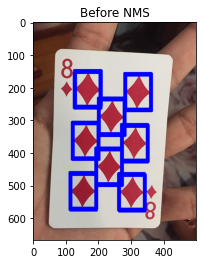

In [20]:
# find all locations in the result map where the matched value is
# greater than the threshold, then clone our original image so we
# can draw on it
(yCoords, xCoords) = np.where(result >= args["threshold"])
clone = image.copy()
print("[INFO] {} matched locations *before* NMS".format(len(yCoords)))

# loop over our starting (x, y)-coordinates
for (x, y) in zip(xCoords, yCoords):
	# draw the bounding box on the image
	cv2.rectangle(clone, (x, y), (x + tW, y + tH), (255, 0, 0), 3)

# show our output image *before* applying non-maxima suppression
plt_imshow("Before NMS", clone)

If we ended our implementation here, we would have a problem — a call to np.where will return all locations of (x, y)-coordinates that are above our threshold.

It could very well be the case that multiple locations refer to the same object. If that happens, we’ll essentially report the same object multiple times, which we want to avoid at all costs.

The solution is to apply non-maxima suppression:

[INFO] 8 matched locations *after* NMS


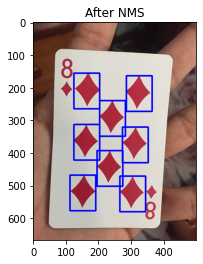

In [21]:
# initialize our list of rectangles
rects = []

# loop over the starting (x, y)-coordinates again
for (x, y) in zip(xCoords, yCoords):
	# update our list of rectangles
	rects.append((x, y, x + tW, y + tH))

# apply non-maxima suppression to the rectangles
pick = non_max_suppression(np.array(rects))
print("[INFO] {} matched locations *after* NMS".format(len(pick)))

# loop over the final bounding boxes
for (startX, startY, endX, endY) in pick:
	# draw the bounding box on the image
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(255, 0, 0), 3)

# show the output image
plt_imshow("After NMS", image)

# Multi-scale Template Matching using Python and OpenCV

In this case, all you need to do is apply a little trick:

1. Loop over the input image at multiple scales (i.e. make the input image progressively smaller and smaller).
2. Apply template matching using cv2.matchTemplate and keep track of the match with the largest correlation coefficient (along with the x, y-coordinates of the region with the largest correlation coefficient).
3. After looping over all scales, take the region with the largest correlation coefficient and use that as your “matched” region.

### The `cv2.matchTemplate` Trick

In [22]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-t", "--template", required=True, help="Path to template image")
#ap.add_argument("-i", "--images", required=True,
#	help="Path to images where template will be matched")
#ap.add_argument("-v", "--visualize",
#	help="Flag indicating whether or not to visualize each iteration")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"template": "data/cod_logo.png",
	"images": "data/TemplateMatching"
}

Applying template matching using edges rather than the raw image gives us a substantial boost in accuracy for template matching.

The reason for this is because the Call of Duty logo is rigid and well defined — and as we’ll see later on in this post, it allows us to discard the color and styling of the logo and instead focus solely on the outline. Doing this gives us a slightly more robust approach that we would not have otherwise.

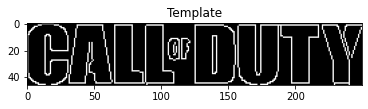

In [23]:
# load the image image, convert it to grayscale, and detect edges
template = cv2.imread(args["template"])
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template = cv2.Canny(template, 50, 200)
(tH, tW) = template.shape[:2]
plt_imshow("Template", template)

### Multi-scale Template Matching Results

In [24]:
np.linspace(0.2, 1.0, 20)[::-1]

array([1.        , 0.95789474, 0.91578947, 0.87368421, 0.83157895,
       0.78947368, 0.74736842, 0.70526316, 0.66315789, 0.62105263,
       0.57894737, 0.53684211, 0.49473684, 0.45263158, 0.41052632,
       0.36842105, 0.32631579, 0.28421053, 0.24210526, 0.2       ])

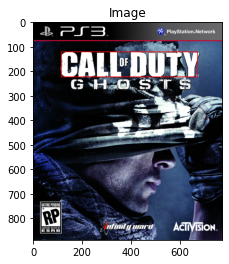

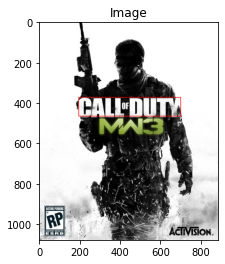

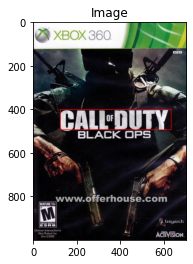

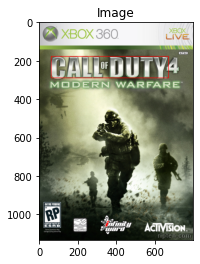

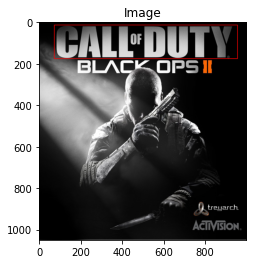

In [25]:
# loop over the images to find the template in
for imagePath in glob.glob(args["images"] + "/*.jpg"):
	# load the image, convert it to grayscale, and initialize the
	# bookkeeping variable to keep track of the matched region
	image = cv2.imread(imagePath)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	found = None

	# loop over the scales of the image
	for scale in np.linspace(0.2, 1.0, 20)[::-1]:
		# resize the image according to the scale, and keep track
		# of the ratio of the resizing
		resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
		r = gray.shape[1] / float(resized.shape[1])

		# if the resized image is smaller than the template, then break
		# from the loop
		if resized.shape[0] < tH or resized.shape[1] < tW:
			break

		# detect edges in the resized, grayscale image and apply template
		# matching to find the template in the image
		edged = cv2.Canny(resized, 50, 200)
		result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)
		(_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

		# check to see if the iteration should be visualized
		if args.get("visualize", False):
			# draw a bounding box around the detected region
			clone = np.dstack([edged, edged, edged])
			cv2.rectangle(clone, (maxLoc[0], maxLoc[1]),
				(maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 2)
			cv2.imshow("Visualize", clone)
			cv2.waitKey(0)

		# if we have found a new maximum correlation value, then ipdate
		# the bookkeeping variable
		if found is None or maxVal > found[0]:
			found = (maxVal, maxLoc, r)

	# unpack the bookkeeping varaible and compute the (x, y) coordinates
	# of the bounding box based on the resized ratio
	(_, maxLoc, r) = found
	(startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
	(endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))

	# draw a bounding box around the detected result and display the image
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
	plt_imshow("Image", image)

# OpenCV Haar Cascades

Haar cascades, first introduced by Viola and Jones in their seminal 2001 publication, [Rapid Object Detection using a Boosted Cascade of Simple Features](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf), are arguably OpenCV’s most popular object detection algorithm.

Sure, many algorithms are more accurate than Haar cascades (HOG + Linear SVM, SSDs, Faster R-CNN, YOLO, to name a few), but they are still relevant and useful today.

That said, Haar cascades are:

* An important part of the computer vision and image processing literature
* Still used with OpenCV
* Still useful, particularly when working in resource-constrained devices when we cannot afford to use more computationally expensive object detectors

## What are Haar cascades?
<image src="images/opencv_haar_cascades_viola_jones.png">

<image src="images/opencv_haar_cascades_haar_features.png">

Figure 4: The 5 different types of Haar-like features extracted from an image patch.
If you are familiar with wavelets, you may see that they bear some resemblance to Haar basis functions and Haar wavelets (where Haar cascades get their name).

To obtain features for each of these five rectangular areas, we simply subtract the sum of pixels under the white region from the sum of pixels under the black region. Interestingly enough, these features have actual real importance in the context of face detection:

1. Eye regions tend to be darker than cheek regions.
2. The nose region is brighter than the eye region.

Therefore, given these five rectangular regions and their corresponding difference of sums, we can form features that can classify parts of a face.

Then, for an entire dataset of features, we use the AdaBoost algorithm to select which ones correspond to facial regions of an image.

Viola and Jones introduced the concept of cascades or stages. At each stop along the sliding window path, the window must pass a series of tests where each subsequent test is more computationally expensive than the previous one. If any one test fails, the window is automatically discarded.

Some Haar cascade benefits are that they’re very fast at computing Haar-like features due to the use of integral images (also called summed area tables). They are also very efficient for feature selection through the use of the AdaBoost algorithm.

## Problems and limitations of Haar cascades
Haar cascades are notoriously prone to false-positives — the Viola-Jones algorithm can easily report a face in an image when no face is present.

Haar cascades are notoriously prone to false-positives — the Viola-Jones algorithm can easily report a face in an image when no face is present.

## How do you use Haar cascades with OpenCV?
The OpenCV library maintains a repository of pre-trained Haar cascades. Most of these Haar cascades are used for either:

* Face detection
* Eye detection
* Mouth detection
* Full/partial body detection

Other pre-trained Haar cascades are provided, including one for Russian license plates and another for cat face detection.



### Implementing OpenCV Haar Cascade object detection (face, eyes, and mouth)

In [26]:
# first, let's get a video which we can use for haar cascade object detection
# !wget https://colab-notebook-videos.s3-us-west-2.amazonaws.com/guitar.mp4

In [27]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-c", "--cascades", type=str, default="cascades",
#	help="path to input directory containing haar cascades")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "cascades": "pyimagesearch/cascades",
    "input": "data/guitar.mp4",
    "output": "output/cascade.avi"
}

In [28]:
# initialize a dictionary that maps the name of the haar cascades to
# their filenames
detectorPaths = {
	"face": "haarcascade_frontalface_default.xml",
	"eyes": "haarcascade_eye.xml",
	"smile": "haarcascade_smile.xml",
}

# initialize a dictionary to store our haar cascade detectors
print("[INFO] loading haar cascades...")
detectors = {}

# loop over our detector paths
for (name, path) in detectorPaths.items():
	# load the haar cascade from disk and store it in the detectors
	# dictionary
	path = os.path.sep.join([args["cascades"], path])
	detectors[name] = cv2.CascadeClassifier(path)

[INFO] loading haar cascades...


In [29]:
'''
# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
	# grab the frame from the video stream, resize it, and convert it
	# to grayscale
	frame = vs.read()
	frame = imutils.resize(frame, width=500)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	
    # perform face detection using the appropriate haar cascade
	faceRects = detectors["face"].detectMultiScale(
		gray, scaleFactor=1.05, minNeighbors=5, minSize=(30, 30),
		flags=cv2.CASCADE_SCALE_IMAGE)

    # loop over the face bounding boxes
	for (fX, fY, fW, fH) in faceRects:
		# extract the face ROI
		faceROI = gray[fY:fY+ fH, fX:fX + fW]
		
        # apply eyes detection to the face ROI
		eyeRects = detectors["eyes"].detectMultiScale(
			faceROI, scaleFactor=1.1, minNeighbors=10,
			minSize=(15, 15), flags=cv2.CASCADE_SCALE_IMAGE)
		
        # apply smile detection to the face ROI
		smileRects = detectors["smile"].detectMultiScale(
			faceROI, scaleFactor=1.1, minNeighbors=10,
			minSize=(15, 15), flags=cv2.CASCADE_SCALE_IMAGE)

        # loop over the eye bounding boxes
		for (eX, eY, eW, eH) in eyeRects:
			# draw the eye bounding box
			ptA = (fX + eX, fY + eY)
			ptB = (fX + eX + eW, fY + eY + eH)
			cv2.rectangle(frame, ptA, ptB, (0, 0, 255), 2)
		
        # loop over the smile bounding boxes
		for (sX, sY, sW, sH) in smileRects:
			# draw the smile bounding box
			ptA = (fX + sX, fY + sY)
			ptB = (fX + sX + sW, fY + sY + sH)
			cv2.rectangle(frame, ptA, ptB, (255, 0, 0), 2)
		
        # draw the face bounding box on the frame
		cv2.rectangle(frame, (fX, fY), (fX + fW, fY + fH),
			(0, 255, 0), 2)

    # show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF
	
    # if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()
'''

'\n# initialize the video stream and allow the camera sensor to warm up\nprint("[INFO] starting video stream...")\nvs = VideoStream(src=0).start()\ntime.sleep(2.0)\n\n# loop over the frames from the video stream\nwhile True:\n\t# grab the frame from the video stream, resize it, and convert it\n\t# to grayscale\n\tframe = vs.read()\n\tframe = imutils.resize(frame, width=500)\n\tgray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)\n\t\n    # perform face detection using the appropriate haar cascade\n\tfaceRects = detectors["face"].detectMultiScale(\n\t\tgray, scaleFactor=1.05, minNeighbors=5, minSize=(30, 30),\n\t\tflags=cv2.CASCADE_SCALE_IMAGE)\n\n    # loop over the face bounding boxes\n\tfor (fX, fY, fW, fH) in faceRects:\n\t\t# extract the face ROI\n\t\tfaceROI = gray[fY:fY+ fH, fX:fX + fW]\n\t\t\n        # apply eyes detection to the face ROI\n\t\teyeRects = detectors["eyes"].detectMultiScale(\n\t\t\tfaceROI, scaleFactor=1.1, minNeighbors=10,\n\t\t\tminSize=(15, 15), flags=cv2.CASCADE_SCA

In [30]:
# grab a reference to the video file and initialize pointer to output
# video file
print("[INFO] opening video file...")
vs = cv2.VideoCapture(args["input"])
writer = None

# loop over the frames from the video stream
while True:
	# grab the next frame
	frame = vs.read()[1]

	# if we did not grab a frame then we have reached the end of the
	# video
	if frame is None:
		break

	# rotate the image 
	# frame = imutils.rotate(frame, -90)
    
    # resize the frame and convert it to grayscale
	frame = imutils.resize(frame, width=500)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

	# perform face detection using the appropriate haar cascade
	faceRects = detectors["face"].detectMultiScale(
		gray, scaleFactor=1.05, minNeighbors=5, minSize=(30, 30),
		flags=cv2.CASCADE_SCALE_IMAGE)

	# loop over the face bounding boxes
	for (fX, fY, fW, fH) in faceRects:
		# extract the face ROI
		faceROI = gray[fY:fY+ fH, fX:fX + fW]

		# apply eyes detection to the face ROI
		eyeRects = detectors["eyes"].detectMultiScale(
			faceROI, scaleFactor=1.1, minNeighbors=10,
			minSize=(15, 15), flags=cv2.CASCADE_SCALE_IMAGE)

		# apply smile detection to the face ROI
		smileRects = detectors["smile"].detectMultiScale(
			faceROI, scaleFactor=1.1, minNeighbors=10,
			minSize=(15, 15), flags=cv2.CASCADE_SCALE_IMAGE)

		# loop over the eye bounding boxes
		for (eX, eY, eW, eH) in eyeRects:
			# draw the eye bounding box
			ptA = (fX + eX, fY + eY)
			ptB = (fX + eX + eW, fY + eY + eH)
			cv2.rectangle(frame, ptA, ptB, (0, 0, 255), 2)

		# loop over the smile bounding boxes
		for (sX, sY, sW, sH) in smileRects:
			# draw the smile bounding box
			ptA = (fX + sX, fY + sY)
			ptB = (fX + sX + sW, fY + sY + sH)
			cv2.rectangle(frame, ptA, ptB, (255, 0, 0), 2)

		# draw the face bounding box on the frame
		cv2.rectangle(frame, (fX, fY), (fX + fW, fY + fH),
			(0, 255, 0), 2)
  
	# if the video writer is None *AND* we are supposed to write
	# the output video to disk initialize the writer
	if writer is None and args["output"] is not None:
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 20,
			(frame.shape[1], frame.shape[0]), True)
  
	# if the writer is not None, write the frame to disk
	if writer is not None:
		writer.write(frame)

# do a bit of cleanup
vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()

[INFO] opening video file...


In [31]:
#!ffmpeg -i output/cascade.avi output/cascade.mp4

# Object detection with deep learning and OpenCV

In the first part of today’s post on object detection using deep learning we’ll discuss Single Shot Detectors and MobileNets.

When combined together these methods can be used for super fast, real-time object detection on resource constrained devices (including the Raspberry Pi, smartphones, etc.)

From there we’ll discover how to use OpenCV’s dnn module to load a pre-trained object detection network.

This will enable us to pass input images through the network and obtain the output bounding box (x, y)-coordinates of each object in the image.

Finally we’ll look at the results of applying the MobileNet Single Shot Detector to example input images.

## Single Shot Detectors for object detection
When it comes to deep learning-based object detection there are three primary object detection methods that you’ll likely encounter:

* Faster R-CNNs (Girshick et al., 2015)
* You Only Look Once (YOLO) (Redmon and Farhadi, 2015)
* Single Shot Detectors (SSDs) (Liu et al., 2015)

Faster R-CNNs are likely the most “heard of” method for object detection using deep learning; however, the technique can be difficult to understand (especially for beginners in deep learning), hard to implement, and challenging to train.

Furthermore, even with the “faster” implementation R-CNNs (where the “R” stands for “Region Proposal”) the algorithm can be quite slow, on the order of 7 FPS.

If we are looking for pure speed then we tend to use YOLO as this algorithm is much faster, capable of processing 40-90 FPS on a Titan X GPU. The super fast variant of YOLO can even get up to 155 FPS.

The problem with YOLO is that it leaves much accuracy to be desired.

SSDs, originally developed by Google, are a balance between the two. The algorithm is more straightforward (and I would argue better explained in the original seminal paper) than Faster R-CNNs.

We can also enjoy a much faster FPS throughput than Girshick et al. at 22-46 FPS depending on which variant of the network we use. SSDs also tend to be more accurate than YOLO. To learn more about SSDs, please refer to Liu et al.

## MobileNets: Efficient (deep) neural networks
<image src="images/mobilenet_depthwise.png">

Figure 2: (Left) Standard convolutional layer with batch normalization and ReLU. (Right) Depthwise separable convolution with depthwise and pointwise layers followed by batch normalization and ReLU (figure and caption from Liu et al.)

The general idea behind depthwise separable convolution is to split convolution into two stages:

A 3×3 depthwise convolution.
Followed by a 1×1 pointwise convolution.
This allows us to actually reduce the number of parameters in our network.

The problem is that we sacrifice accuracy — MobileNets are normally not as accurate as their larger big brothers…

…but they are much more resource efficient.

For more details on MobileNets please see Howard et al.

## Combining MobileNets and Single Shot Detectors for fast, efficient deep-learning based object detection
If we combine both the MobileNet architecture and the Single Shot Detector (SSD) framework, we arrive at a fast, efficient deep learning-based method to object detection.

The model we’ll be using in this blog post is a Caffe version of the [original TensorFlow implementation](https://github.com/Zehaos/MobileNet) by Howard et al. and was trained by chuanqi305 ([see GitHub](https://github.com/chuanqi305/MobileNet-SSD)).

The MobileNet SSD was first trained on the COCO dataset (Common Objects in Context) and was then fine-tuned on PASCAL VOC reaching 72.7% mAP (mean average precision).

We can therefore detect 20 objects in images (+1 for the background class), including airplanes, bicycles, birds, boats, bottles, buses, cars, cats, chairs, cows, dining tables, dogs, horses, motorbikes, people, potted plants, sheep, sofas, trains, and tv monitors.



### Deep learning-based object detection with OpenCV

In [40]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to input image")
#ap.add_argument("-p", "--prototxt", required=True,
#	help="path to Caffe 'deploy' prototxt file")
#ap.add_argument("-m", "--model", required=True,
#	help="path to Caffe pre-trained model")
#ap.add_argument("-c", "--confidence", type=float, default=0.2,
#	help="minimum probability to filter weak detections")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "data/objectDetection/example_03.jpg",
	"prototxt": "pyimagesearch/MobileNetSSD_deploy.prototxt.txt",
	"model": "pyimagesearch/MobileNetSSD_deploy.caffemodel",
	"confidence": 0.2
}

In [41]:
# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])

# load the input image and construct an input blob for the image
# by resizing to a fixed 300x300 pixels and then normalizing it
# (note: normalization is done via the authors of the MobileNet SSD
# implementation)
image = cv2.imread(args["image"])
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)

[INFO] loading model...


In [42]:
# pass the blob through the network and obtain the detections and
# predictions
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


[INFO] horse: 99.90%
[INFO] pottedplant: 97.92%
[INFO] person: 56.05%


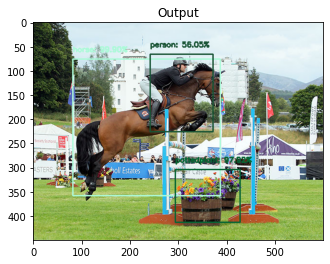

In [43]:
# loop over the detections
for i in np.arange(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# extract the index of the class label from the `detections`,
		# then compute the (x, y)-coordinates of the bounding box for
		# the object
		idx = int(detections[0, 0, i, 1])
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# display the prediction
		label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
		print("[INFO] {}".format(label))
		cv2.rectangle(image, (startX, startY), (endX, endY),
			COLORS[idx], 2)
		y = startY - 15 if startY - 15 > 15 else startY + 15
		cv2.putText(image, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

# show the output image
plt_imshow("Output", image)

# Real-time object detection with deep learning and OpenCV


In [44]:
# import the necessary packages
from imutils.video import FPS

### Object detection in video with deep learning and OpenCV

In [45]:
# first, let's get a video on which we can run our face mask detector 
#!wget https://colab-notebook-videos.s3-us-west-2.amazonaws.com/janie.mp4

--2021-05-15 20:19:16--  https://colab-notebook-videos.s3-us-west-2.amazonaws.com/janie.mp4
Resolving colab-notebook-videos.s3-us-west-2.amazonaws.com (colab-notebook-videos.s3-us-west-2.amazonaws.com)... 52.92.160.26
Connecting to colab-notebook-videos.s3-us-west-2.amazonaws.com (colab-notebook-videos.s3-us-west-2.amazonaws.com)|52.92.160.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3413203 (3.3M) [video/mp4]
Saving to: ‘janie.mp4’

janie.mp4           100%[===================>]   3.25M   505KB/s    in 7.2s    

2021-05-15 20:19:25 (464 KB/s) - ‘janie.mp4’ saved [3413203/3413203]



In [46]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--prototxt", required=True,
#	help="path to Caffe 'deploy' prototxt file")
#ap.add_argument("-m", "--model", required=True,
#	help="path to Caffe pre-trained model")
#ap.add_argument("-c", "--confidence", type=float, default=0.2,
#	help="minimum probability to filter weak detections")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"input" : "data/janie.mp4",
	"output" : "output/janie.avi",
	"prototxt": "pyimagesearch/MobileNetSSD_deploy.prototxt.txt",
	"model": "pyimagesearch/MobileNetSSD_deploy.caffemodel",
	"confidence" : 0.5
}

In [47]:
# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])

[INFO] loading model...


In [ ]:
'''
# initialize the video stream, allow the cammera sensor to warmup,
# and initialize the FPS counter
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)
fps = FPS().start()
'''

In [ ]:
'''
# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)
	
    # grab the frame dimensions and convert it to a blob
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)),
		0.007843, (300, 300), 127.5)
	
    # pass the blob through the network and obtain the detections and
	# predictions
	net.setInput(blob)
	detections = net.forward()

    # loop over the detections
	for i in np.arange(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the prediction
		confidence = detections[0, 0, i, 2]
		
        # filter out weak detections by ensuring the `confidence` is
		# greater than the minimum confidence
		if confidence > args["confidence"]:
			# extract the index of the class label from the
			# `detections`, then compute the (x, y)-coordinates of
			# the bounding box for the object
			idx = int(detections[0, 0, i, 1])
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")
			
            # draw the prediction on the frame
			label = "{}: {:.2f}%".format(CLASSES[idx],
				confidence * 100)
			cv2.rectangle(frame, (startX, startY), (endX, endY),
				COLORS[idx], 2)
			y = startY - 15 if startY - 15 > 15 else startY + 15
			cv2.putText(frame, label, (startX, y),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

    # show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF
	
    # if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break
	# update the FPS counter
	fps.update()

# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()
'''

In [48]:
# grab a reference to the video file, initialize pointer to output
# video file, and initialize the FPS counter
print("[INFO] opening video file...")
vs = cv2.VideoCapture(args["input"])
writer = None
fps = FPS().start()

[INFO] opening video file...


In [49]:
# loop over the frames from the video stream
while True:
	# grab the next frame
	frame = vs.read()[1]

	# if we did not grab a frame then we have reached the end of the
	# video
	if frame is None:
		break
	
	# resize the frame to have a maximum width of 400 pixels
	frame = imutils.resize(frame, width=400)

	# grab the frame dimensions and convert it to a blob
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 0.007843, (300, 300), 127.5)
 
	# pass the blob through the network and obtain the detections and
	# predictions
	net.setInput(blob)
	detections = net.forward()
 
 	# loop over the detections
	for i in np.arange(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the prediction
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the `confidence` is
		# greater than the minimum confidence
		if confidence > args["confidence"]:
			# extract the index of the class label from the
			# `detections`, then compute the (x, y)-coordinates of
			# the bounding box for the object
			idx = int(detections[0, 0, i, 1])
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")
   
			# draw the prediction on the frame
			label = "{}: {:.2f}%".format(CLASSES[idx],
				confidence * 100)
			cv2.rectangle(frame, (startX, startY), (endX, endY),
				COLORS[idx], 2)
			y = startY - 15 if startY - 15 > 15 else startY + 15
			cv2.putText(frame, label, (startX, y),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
   
	# update the FPS counter
	fps.update()

	# if the video writer is None *AND* we are supposed to write
	# the output video to disk initialize the writer
	if writer is None and args["output"] is not None:
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 20,
			(frame.shape[1], frame.shape[0]), True)
  
	# if the writer is not None, write the frame with recognized
	# faces to disk
	if writer is not None:
		writer.write(frame)
  
# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()

[INFO] elapsed time: 63.55
[INFO] approx. FPS: 1.98


In [ ]:
#!ffmpeg -i output.avi output.mp4